# Image Caption Generator

In this project, we built an image caption generator. The generator is capable of generating a caption based on the image supplied to it. This project combines computer vision and natural language processing using a combined architecture of a CNN and an LSTM. The dataset chosen to train our model can be downloaded from this github https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip and https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip. The Flickr_8k_text folder contains the Flickr8k.token file, which is the main file in our dataset and contains the names of the images and their respective captions separated by a new line.


In [ ]:
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import numpy as np
import zipfile
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer # Changed import location
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import add # Changed import location
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout
from tensorflow.keras.utils import custom_object_scope
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import argparse

In [ ]:
zip_file_path = '/content/Flickr8k_Dataset.zip'
extract_path = '/content/images'

In [ ]:
# This will uncompress our file ans store it to our extract_path
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
# Load our data contains in a folder
def load_data(filename):
  file = open(filename,'r')
  text = file.read()
  file.close()
  return text

In [ ]:
# Load our images, each image will associated with five captions
def get_images_with_captions(filename):
  file = load_data(filename)
  captions = file.split('\n')
  descriptions = {}
  for caption in captions[:-1]:
    img,caption = caption.split('\t')
    if img[:-2] not in descriptions:
      descriptions[img[:-2]] = [caption]
    else:
      descriptions[img[:-2]].append(caption)
  return descriptions


In [ ]:
# This method cleans up our text by removing punctuation and words containing numbers, and lowering words.
def cleaning_text(captions):
  table = str.maketrans('','',string.punctuation)
  for img,caps in captions.items():
    for i,img_caption in enumerate(caps):
            img_caption.replace("-"," ")
            desc = img_caption.split()
            desc = [word.lower() for word in desc]
            desc = [word.translate(table) for word in desc]
            desc = [word for word in desc if(len(word)>1)]
            desc = [word for word in desc if(word.isalpha())]
            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions

In [ ]:
# We create with this function our vocabulary
def build_text_vocabulary(descriptions):
  vocab = set()
  for key in descriptions.keys():
    [vocab.update(d.split()) for d in descriptions[key]]
  return vocab

In [ ]:
# saving the description in a file
def save_descriptions(descriptions,filename):
  lines = list()
  for key, desc_list in descriptions.items():
    for desc in desc_list:
      lines.append(key + '\t' + desc )
    data = "\n".join(lines)
  file = open(filename,"w")
  file.write(data)
  file.close()

In [ ]:
# Extract features from our images by passing them to our pre-built model.
def extract_features_from_images(directory):
  model = Xception(include_top=False,pooling='avg')
  features = {}
  for img in tqdm(os.listdir(directory)):
    filename = directory + "/" + img
    image = Image.open(filename)
    image = image.resize((299,299))
    image = np.expand_dims(image, axis=0)
    image = image/127.5
    image = image - 1.0
    feature = model.predict(image)
    features[img] = feature
  return features

In [ ]:
# Here are the path from our dataser, the token file and the folder containing the images
dataset_text = "/content/text/Flickr8k.token.txt"
dataset_images = "/content/images/Flicker8k_Dataset"
#filename = dataset_text + "/" + "Flickr8k.token.txt"

In [ ]:
descriptions = get_images_with_captions(dataset_text)
print("Length of descriptions =" ,len(descriptions))

Length of descriptions = 8092


In [ ]:
#for each image it will find find five captions that describe the image
descriptions['2094543127_46d2f1fedf.jpg']

["A girl holding a crocodile 's mouth closed",
 'A girl is posed over a statue of a dangerous animal .',
 'A girl sits on what appears to be a crocodile .',
 'A girl sitting on top of a crocodile',
 'A girl with red hair is sitting on a crocodile holding its jaw .']

In [ ]:
#cleaning the datas by removing from lower casing,punctuations and word containing numbers
clean_descriptions = cleaning_text(descriptions)

In [ ]:
clean_descriptions['2094543127_46d2f1fedf.jpg']

["A girl holding a crocodile 's mouth closed",
 'A girl is posed over a statue of a dangerous animal .',
 'A girl sits on what appears to be a crocodile .',
 'A girl sitting on top of a crocodile',
 'A girl with red hair is sitting on a crocodile holding its jaw .']

In [ ]:
#building our vocabulary using our clean text description
vocabulary = build_text_vocabulary(clean_descriptions)

In [ ]:
vocabulary

{'extreme',
 'sidewalk',
 'hapily',
 'small',
 'parasails',
 'shaved',
 'tongue',
 'comprised',
 'on-lookers',
 'then',
 'monitoring',
 'photo',
 'daytime',
 'zipping',
 'zaftig',
 'mural',
 'ladies',
 'reenactors',
 'bullseye',
 'sheilding',
 'pinestraw',
 'medatative',
 'direction',
 'palace',
 'protruding',
 'ankle-deep',
 'barista',
 'troupe',
 'siren',
 'boredom',
 'panties',
 'viewing',
 'roller-coaster',
 'teamates',
 'waring',
 '33',
 'electrical',
 'bay',
 'country',
 'somersault',
 'close-cropped',
 'different',
 'throws',
 'helmeted',
 'Axe',
 'gay',
 'Women',
 'lettuce',
 'tracksuit',
 'Puppies',
 'colonial',
 'breaststroke',
 'farmer',
 'sister',
 'returns',
 'combat',
 'peddles',
 'rock-climbing',
 'bottle',
 'crosswalk',
 'Weirmeiner',
 'midpitch',
 'gra',
 'aggitates',
 'facepaintings',
 'Biden',
 'AIG',
 'graffiti-filled',
 'armoire',
 'signs',
 'sveral',
 'garb',
 'zips',
 'again',
 'expansive',
 'hamming',
 'engulf',
 'flexible',
 'weeping',
 'Beijing',
 'long-distan

In [ ]:
#saving our descriptions after the preprocessing this will avoid us to repeat the process
save_descriptions(clean_descriptions, "descriptions.txt")

In [ ]:
features = extract_features_from_images(dataset_images)

In [ ]:
dump(features, open("features.p","wb"))

In [ ]:
features = load(open("/content/features.p","rb"))

In [ ]:
def load_photos(filename):
    file = load_data(filename)
    photos = file.split("\n")[:-1]
    return photos

In [ ]:
def load_clean_descriptions(filename, photos):

  file = load_data(filename)
  descriptions = {}
  for line in file.split("\n"):
    words = line.split()
    if len(words)<1 :
      continue
    image, image_caption = words[0], words[1:]
    if image in photos:
      if image not in descriptions:
        descriptions[image] = []
        desc = '<start> ' + " ".join(image_caption) + ' <end>'
        descriptions[image].append(desc)
  return descriptions

In [ ]:
def load_features(photos):
    all_features = load(open("features.p","rb"))
    features = {k:all_features[k] for k in photos}
    return features

In [ ]:
train_imgs = load_photos("/content/text/Flickr_8k.trainImages.txt")

In [ ]:
train_descriptions = load_clean_descriptions("/content/descriptions.txt", train_imgs)

In [ ]:
train_features = load_features(train_imgs)

In [ ]:
def dict_to_list(descriptions):
  all_desc = []
  for key in descriptions.keys():
    [all_desc.append(d) for d in descriptions[key]]
    return all_desc

In [ ]:
def create_tokenizer(descriptions):
  desc_list = dict_to_list(descriptions)
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(desc_list)
  return tokenizer

In [ ]:
def max_length(descriptions):
  desc_list = dict_to_list(descriptions)
  return max(len(d.split()) for d in desc_list)

In [ ]:
tokenizer = create_tokenizer(train_descriptions)

In [ ]:
dump(tokenizer, open('tokenizer.p', 'wb'))

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

16

In [ ]:
max_length = max_length(descriptions)
max_length

14

In [ ]:
def create_sequences(tokenizer, max_length, desc_list, feature):
  X1, X2, y = list(), list(), list()
  for desc in desc_list:
    # encode the sequence
    seq = tokenizer.texts_to_sequences([desc])[0]
    # split one sequence into multiple X,y pairs
    for i in range(1, len(seq)):
      # split into input and output pair
      in_seq, out_seq = seq[:i], seq[i]
      # pad input sequence
      in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
      # encode output sequence
      out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
      # store
      X1.append(feature)
      X2.append(in_seq)
      y.append(out_seq)
  return np.array(X1), np.array(X2), np.array(y)

In [ ]:
def data_generator(descriptions, features, tokenizer, max_length):
  while 1:
    for key, description_list in descriptions.items():
      feature = features[key][0]
      input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
      #yield [[input_image, input_sequence], output_word]
      #yield ([input_image,input_sequence],output_word)
      yield ((input_image,input_sequence),output_word)


In [ ]:
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))

In [ ]:
a.shape, b.shape, c.shape

((15, 2048), (15, 14), (15, 16))

In [ ]:
# it is the numbers of features that we have
input_shape = 2048
epochs = 10
steps = len(train_descriptions)

In [ ]:
def custom_model(vocab_size, max_length,input_shape):
  input = Input(shape=(input_shape,))
  x = Dropout(0.1)(input)
  x = Dense(256, activation='relu')(x)

  lstminput = Input(shape=(max_length,))
  x2 = Embedding(vocab_size,256,mask_zero=True)(lstminput)
  x2 = Dropout(0.5)(x2)
  x2 = LSTM(256)(x2)

  decoder = add([x,x2])
  decoder = Dense(256,activation='relu')(decoder)
  output = Dense(vocab_size,activation='softmax')(decoder)

  model = Model(inputs=[input,lstminput],outputs=output)
  model.compile(loss='categorical_crossentropy', optimizer='adam')

  return model

In [ ]:
simple_model = custom_model(vocab_size, max_length,input_shape)

In [ ]:
simple_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 14)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_11      │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 14, 256)   │      4,096 │ input_layer_12[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 2048)      │          0 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 14, 256)   │          0 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (None, 14)        │          0 │ input_layer_12[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 256)       │    524,544 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 256)       │    525,312 │ dropout_8[0][0],  │
│                     │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_27 (Add)        │ (None, 256)       │          0 │ dense_10[0][0],   │
│                     │                   │            │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 256)       │     65,792 │ add_27[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 16)        │      4,112 │ dense_11[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,123,856 (4.29 MB)

 Trainable params: 1,123,856 (4.29 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 16
Description Length:  14


In [ ]:
generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
print(generator)

<generator object data_generator at 0x7fe0874ca180>


In [ ]:
for i in range(epochs):
  generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
  custom_model.fit(generator, epochs=1, steps_per_epoch= steps, verbose=1)
  custom_model.save("models/model_" + str(i) + ".h5")

6000/6000 ━━━━━━━━━━━━━━━━━━━━ 291s 48ms/step - loss: 1.5980


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 288s 48ms/step - loss: 1.5068


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 286s 48ms/step - loss: 1.4629


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 284s 47ms/step - loss: 1.4360


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 285s 48ms/step - loss: 1.4069


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 284s 47ms/step - loss: 1.3760


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 284s 47ms/step - loss: 1.3509


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 284s 47ms/step - loss: 1.3169


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 286s 48ms/step - loss: 1.3025


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 285s 47ms/step - loss: 1.2921


In [ ]:
image_path  = '/content/10815824_2997e03d76.jpg'

In [ ]:
def image_features(filename, model):
  try:
    image = Image.open(filename)
  except:
    print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
  image = image.resize((299,299))
  image = np.array(image)
  # for images that has 4 channels, we convert them into 3 channels
  if image.shape[2] == 4:
    image = image[..., :3]
  image = np.expand_dims(image, axis=0)
  image = image/127.5
  image = image - 1.0
  feature = model.predict(image)
  return feature

In [ ]:
def word_for_id(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None

In [ ]:
def generate_desc(model, tokenizer, photo, max_length):
  in_text = 'start'
  for i in range(max_length):
    sequence = tokenizer.texts_to_sequences([in_text])[0]
    sequence = pad_sequences([sequence], maxlen=max_length,padding='post') #[0]
    pred = model.predict([photo,sequence], verbose=0)
    pred = np.argmax(pred)
    word = word_for_id(pred, tokenizer)
    if word is None:
      break
    if word == 'end':
      break
    in_text += ' ' + word
    if word == 'end':
      break
  return in_text

In [ ]:
max_length = 14
tokenizer = load(open("/content/tokenizer.p","rb"))
xception_model = Xception(include_top=False, pooling="avg")

In [ ]:
vselected_model = custom_model(vocab_size,max_length,2048)

In [ ]:
vselected_model.load_weights("/content/model_9.h5")

In [ ]:
img_path = "/content/667626_18933d713e.jpg"

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step



start laying down on the beach end


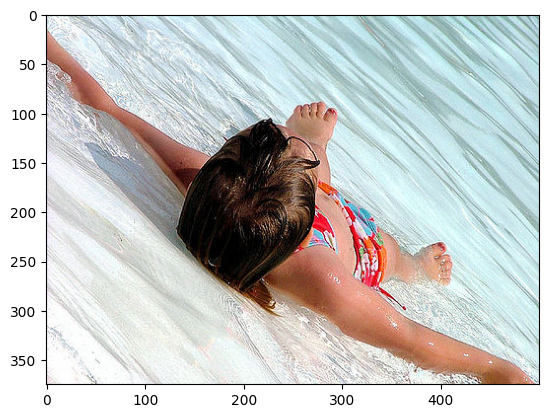

In [ ]:
photo = image_features(img_path, xception_model)
img = Image.open(img_path)
generated_description = generate_desc(vselected_model, tokenizer, photo, max_length)
print("\n\n")
print(generated_description)
plt.imshow(img)